an example:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

##### DATA #####
curve_length = 100
num_parameters = 3

num_samples = 2000

X = torch.randn(num_samples, curve_length)

A = torch.randn(num_samples, num_parameters)

X_train, X_val = X[:1500], X[1500:]
A_train, A_val = A[:1500], A[1500:]

##### Model with dropout? #####

class CurveRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.net(x)
    
model = CurveRegressor(curve_length, num_parameters)

##### Training - Setup #####

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

##### Training - Loop #####

for epoch in range(20):
    model.train()
    optimizer.zero_grad()

    preds = model(X_train)
    loss = criterion(preds, A_train)

    loss.backward()
    optimizer.step()

    # validation loss
    with torch.no_grad():
        model.eval()
        val_loss = criterion(model(X_val), A_val)

    print(f"Epoch {epoch:02d} | train loss: {loss.item():.4f} | val loss: {val_loss.item():.4f}")

##### inference with uncertainty #####

# random new curve
x_new = torch.randn(1, curve_length)

num_samples_mc = 50
preds = []

model.train()

with torch.no_grad():
    for _ in range(num_samples_mc):
        preds.append(model(x_new))

preds = torch.stack(preds) # shape [num_samples_mc, 1, num_parameters]

mean_prediction = preds.mean(dim = 0)
std_prediction = preds.std(dim = 0)

print("\nMean prediction:\n", mean_prediction)
print("\nStd dev (uncertainty):\n", std_prediction)

okay, lets do the real thing now

# notes:
something something things are more stable with normalisation? idk how to scale and unscale everything :(

maybe abstractify reading in data cube (possible) - this is already done lmao, its effectively a path + one liner
and spectrum to fit (less possible as the spectra have no standardised way of being saved - but could make e.g. a JWST method, a HST method, etc... but maybe later lmao) 

In [1]:
%matplotlib widget

LTT


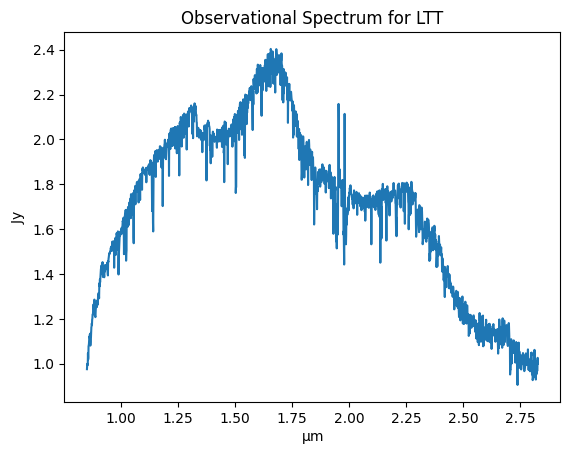

appending values from data cube to y_curves, params lists: 100%|██████████| 2106/2106 [00:22<00:00, 92.57it/s] 


In [1]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from itertools import product
from tqdm import tqdm
from astropy.visualization import quantity_support
quantity_support() # required for numpy to not get annoyed when doing e.g. np.stack()
from joblib import Parallel, delayed

from spots_and_faculae_model.readers import read_JWST_fits
from spots_and_faculae_model.spectrum import spectrum
from spots_and_faculae_model.spectrum_grid import spectrum_grid

"""
one difference between this and main.ipynb is that here the spectra are processed by appending rows into the matrix A, whereas in main.ipynb spectra are appended as _columns_ into the matrix A
"""

# read in spectrum to fit
external_spectrum_path = Path("../../assets/MAST_2025-10-26T11_57_04.058Z - LTT/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg001_nis_x1dints.fits")
script_dir = os.getcwd()
wavelength_grid_absolute_path = (script_dir / external_spectrum_path).resolve()
spectrum_to_decompose : spectrum = read_JWST_fits(wavelength_grid_absolute_path, name = "LTT")
print(spectrum_to_decompose.Name)
mask = np.isfinite(spectrum_to_decompose.Fluxes) # mask that removes np.inf values from spectra - this could be observational spectra dependent; so we have to apply this to the data cube after creating the data cube, not before
spectrum_to_decompose = spectrum_to_decompose[mask]
spectrum_to_decompose.normalise_Janskys()

spectrum_to_decompose.plot()

# read in spectral cube
spectral_grid_relative_path = Path("../../assets/spectral_grid.hdf5")
spectral_grid_absolute_path = (script_dir / spectral_grid_relative_path).resolve()
spec_grid : spectrum_grid = spectrum_grid.from_hdf5_file(absolute_hdf5_path=spectral_grid_absolute_path)
# print(spec_grid.Table)

# read in spectrum to decompose - use it to determine the following 
spectrum_num_points = len(spectrum_to_decompose)

# read in data cube - use it to determine the following
number_phoenix_spectra : int = len(spec_grid.T_effs) * len(spec_grid.FeHs) * len(spec_grid.log_gs) # number of spectra we'll use for train/val

# so each ROW in X,A is 1 graph
# and the columns of X are just the graph values (ys)
# and the columns of X are the different parameters )

# effectively we're doing the same thing as in main.ipynb, but without the horrendous bodge for working out what the weights are
# here, we're being systematic about the weights and their meaning by appending them all to a matrix (# of PHOENIX spectra rows x 3 columns) beforehand
y_curves = []
params = []

def get_spectra_and_params(T_eff, FeH, log_g, mask, spectrum_to_decompose) -> tuple[np.array, np.array]:
    fluxes : np.ndarray = spec_grid.process_single_spectral_component(T_eff=T_eff, FeH=FeH, log_g=log_g, mask=mask, spectrum_to_decompose=spectrum_to_decompose)
    params = [T_eff.value, FeH, log_g]
    
    return fluxes, params

fluxes_and_params = Parallel(n_jobs=-1, prefer="threads")(
    delayed(get_spectra_and_params)(T_eff, FeH, log_g, mask=mask, spectrum_to_decompose=spectrum_to_decompose) for T_eff, FeH, log_g in tqdm(product(spec_grid.T_effs, spec_grid.FeHs, spec_grid.log_gs), total=len(spec_grid.T_effs) * len(spec_grid.FeHs) * len(spec_grid.log_gs), desc="appending values from data cube to y_curves, params lists")
    )

y_curves, params = zip(*fluxes_and_params)  # each element of results is (y_curve, param)

# params is a list of lists of the form [T_eff, FeH, log_g]

In [10]:
print(y_curves[:100])
print(params[:100])

(<Quantity [1.        , 0.99374489, 0.9870837 , ..., 0.36280881, 0.36220436,
           0.35725597] Jy>, <Quantity [1.        , 0.99571082, 0.99096869, ..., 0.38949416, 0.38855591,
           0.38297054] Jy>, <Quantity [1.        , 0.9964802 , 0.99243449, ..., 0.50757561, 0.50663621,
           0.49825534] Jy>, <Quantity [1.        , 0.99669329, 0.99274044, ..., 0.73705804, 0.73669932,
           0.72159068] Jy>, <Quantity [1.        , 0.99679764, 0.99282874, ..., 1.05832913, 1.05774563,
           1.0302902 ] Jy>, <Quantity [1.        , 0.99653066, 0.99212145, ..., 1.51244514, 1.51304417,
           1.46416798] Jy>, <Quantity [1.        , 0.99639384, 0.99171778, ..., 2.0745862 , 2.07486743,
           1.9967308 ] Jy>, <Quantity [1.        , 0.99644764, 0.99182058, ..., 2.69803188, 2.69616098,
           2.59357882] Jy>, <Quantity [1.        , 0.99683029, 0.99287952, ..., 3.36298308, 3.35867078,
           3.25873165] Jy>, <Quantity [1.        , 0.9973084 , 0.99409223, ..., 3.99721998,

In [ ]:
# in this block we combine some y curves of different parameters to mimic spots

combination_ys = []
combination_parameters = []

number_of_combined_curves_to_generate : int = 5*len(y_curves)

number_of_components_to_use = 3

number_parameters : int = number_of_components_to_use * 4 # (weight, T_eff, FeH, log_g) x number_of_components_to_use, weight_a, weight_b

import random

for i in tqdm(range(number_of_combined_curves_to_generate), total=number_of_combined_curves_to_generate):
    # or could use e.g. num = random.uniform(0, 0.3) for a uniform float between 0 and 0.3
    weights = np.random.dirichlet(alpha=np.ones(number_of_components_to_use))  # shape (n,)
    
    y_combination = np.zeros_like(y_curves[0]) # length of the spectrum
    parameters = [] # this will end up being number_of_components_to_use lots of (weight, T_eff, FeH, log_g)
    
    for weight in weights:
        spectrum_index = random.randint(0, len(y_curves) - 1)

        y_combination += weight * y_curves[spectrum_index]
        parameters.extend([weight, *params[spectrum_index]])

    # add some noise here too
    noise_max_amplitude = max(y_combination.value) / 1000
    y_combination += np.random.uniform(low=-noise_max_amplitude, high=noise_max_amplitude, size=len(y_combination)) * y_combination[0].unit 
    
    combination_ys.append(y_combination)
    combination_parameters.append(parameters)


100%|██████████| 10530/10530 [00:01<00:00, 5908.99it/s]


[<Quantity [0.99938442, 0.99732618, 0.99330404, ..., 1.96961742, 1.97098361,
            1.90063367] Jy>,
 <Quantity [1.00174553, 0.99615804, 0.99587843, ..., 0.85240006, 0.90296014,
            0.82412028] Jy>]

[[np.float64(0.7003917041892291),
  np.float64(3000.0),
  np.float64(-3.0),
  np.float64(5.5),
  np.float64(0.1232320974657803),
  np.float64(3600.0),
  np.float64(-3.0),
  np.float64(4.0),
  np.float64(0.17637619834499066),
  np.float64(3200.0),
  np.float64(-2.0),
  np.float64(0.0)],
 [np.float64(0.4443903111136209),
  np.float64(4000.0),
  np.float64(-0.5),
  np.float64(0.0),
  np.float64(0.2205289858053505),
  np.float64(2600.0),
  np.float64(-2.0),
  np.float64(1.0),
  np.float64(0.33508070308102866),
  np.float64(3900.0),
  np.float64(1.0),
  np.float64(1.5)]]

In [ ]:
display(combination_ys[:2])
display(combination_parameters[:2])

In [3]:
# X = np.stack([y_curves for spectrum in data_cube(1...number_phoenix_spectra)])
X = np.stack(combination_ys)

# A = np.stack([list_of_params_that_describe_curve_1,...,number_parameters])
A = np.stack(combination_parameters)

from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_tensor = torch.tensor(X_scaler.fit_transform(X), dtype=torch.float32)

A_scaler = StandardScaler()
A_tensor = torch.tensor(A_scaler.fit_transform(A), dtype=torch.float32)

# X_tensor = torch.tensor(X, dtype=torch.float32)
# A_tensor = torch.tensor(A, dtype=torch.float32)

training_fraction : float = 0.7
validation_fraction : float = 1.0 - training_fraction

cutoff : int = int(number_phoenix_spectra * training_fraction)

X_train, X_val = X_tensor[:cutoff], X_tensor[cutoff:]
A_train, A_val = A_tensor[:cutoff], A_tensor[cutoff:]

In [4]:
display(X_train)
display(A_train)

tensor([[-0.9908, -2.9026, -2.6513,  ..., -1.0622, -1.0570, -1.0019],
        [ 0.0311, -1.1231, -0.7896,  ..., -0.8536, -0.8719, -0.8640],
        [ 1.3958,  0.2609,  0.6953,  ..., -0.4078, -0.4145, -0.4134],
        ...,
        [ 1.8429,  0.4895,  1.4852,  ...,  3.2555,  3.2407,  3.1555],
        [-1.6116,  1.1401,  1.4839,  ...,  0.2596,  0.2997,  0.2395],
        [ 0.7728, -0.1969, -0.0766,  ..., -0.2017, -0.2078, -0.2051]])

tensor([[-1.1394, -0.8668,  0.7617,  ..., -1.0697, -1.8373,  1.0528],
        [-0.2289, -1.6420,  1.0871,  ..., -1.4555, -1.1894, -1.3448],
        [ 0.5671,  0.4898,  1.4125,  ...,  0.8595,  0.1062,  0.5200],
        ...,
        [-0.8458,  1.6525,  0.1109,  ..., -0.2980, -1.8373,  0.7864],
        [-1.3599,  0.4898,  0.7617,  ...,  0.8595, -0.2177, -0.2792],
        [ 1.3718,  0.2960, -0.2145,  ...,  0.4736,  1.0780, -1.3448]])

In [6]:
class CurveRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            # nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = CurveRegressor(spectrum_num_points, number_parameters)

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)#, weight_decay=1e-4)

max_epochs : int = 1600
progress_bar = tqdm(range(max_epochs), desc=f"Initialising...")

best_val_loss = np.inf
patience_counter = 0
patience = 10

for epoch in progress_bar:
    model.train()
    optimizer.zero_grad()

    preds = model(X_train)
    loss = criterion(preds, A_train)

    loss.backward()
    optimizer.step()

    # validation loss
    with torch.no_grad():
        model.eval()
        val_loss = criterion(model(X_val), A_val)
    
    progress_bar.set_description(f"Epoch {epoch:02d} | train loss: {loss:.4f} | val loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("[ML] : early stopping")
        break

Epoch 246 | train loss: 0.8315 | val loss: 0.8474:  15%|█▌        | 246/1600 [00:05<00:31, 43.62it/s]

[ML] : early stopping


In [18]:

num_samples_mc = 500 # number of Monte Carlo forward passes used for MC-Dropout to estimate uncertainty.
preds = []

model.train()

# scale fluxes by same X_scaler that we used to scale the training data
x_input_scaled = X_scaler.transform(spectrum_to_decompose.Fluxes.reshape(1, -1))
x_tensor = torch.tensor(x_input_scaled, dtype=torch.float32)

# x_tensor = torch.tensor(spectrum_to_decompose.Fluxes, dtype=torch.float32)

with torch.no_grad():
    for _ in range(num_samples_mc):
        preds.append(model(x_tensor))

preds = torch.stack(preds) # shape [num_samples_mc, 1, number_parameters]

mean_prediction = preds.mean(dim = 0)
std_prediction = preds.std(dim = 0)

# print("Mean prediction")
# print(f"T_eff = {mean_prediction[0]}")
# print(f"FeH = {mean_prediction[1]}")
# print(f"log_g = {mean_prediction[2]}")

# print("Std dev (uncertainty)")
# print(f"T_eff = {std_prediction[0]}")
# print(f"FeH = {std_prediction[1]}")
# print(f"log_g = {std_prediction[2]}")

mean_pred_scaled = mean_prediction.detach().numpy()
mean_pred_physical : np.array = A_scaler.inverse_transform(mean_pred_scaled.reshape(1, -1))[0]

std_pred_scaled = std_prediction.detach().numpy()
std_pred_physical = std_pred_scaled * A_scaler.scale_

import pandas as pd

n_variables = 4

column_names = ["Weight", "T_eff", "FeH", "log_g"]

# Convert list to array
arr = np.array(mean_pred_physical)

# Build dictionary dynamically using the string variables
data = {name: arr[i::n_variables] for i, name in enumerate(column_names)}

# Create DataFrame
df = pd.DataFrame(data)

print(df)

     Weight        T_eff       FeH     log_g
0  0.434330  3755.698486  0.354799  5.212174
1  0.255479  3382.356445 -0.483156  5.550766
2  0.308293  3333.508789 -0.114939  5.197769
